In [1]:
# import PyQt6.QtCore
import os
os.environ["QT_API"] = "pyqt5"
import matplotlib.pyplot as plt

# Use qt backend for matplotlab to use interactive mne plots
%matplotlib qt

In [2]:
import mne 
import analysis.processing
import pandas as pd
import csv 
import os
from config import Config
configObj = Config()
configss = configObj.getConfigSnapshot()

mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

In [3]:
analysis.processing.segmentData([1], preprocess = True)

c:\Users\erang\Desktop\Reading_task\src\analysis\processing.py:55: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)


In [ ]:
for pnum in (1,2,4):
    for b_cnt in range (0, 2):
        block_nums = [ x+ (str(b_cnt)) for x in ['D', 'ND']  ]
        for block_num in block_nums:
            raw = analysis.processing.loadSegmentedData(pnum, block_num)
            epochs = analysis.processing.epochContinuousData(raw)
            
            participant_number = 'P' + str(pnum)
            partipant_data_path =  'Pilot'+ '/'+ participant_number + '/' + block_num +'-epo.fif'
            path = os.path.join(configss['root'], configss['data_dir'] , partipant_data_path ) 

            epochs.save(path, overwrite= True)
            
        

c:\Users\erang\Desktop\Reading_task\src\analysis\processing.py:26: RuntimeWarning: This filename (c:\Users\erang\Desktop\Reading_task\ov_experiment/scenarios/data\Pilot/P1/D0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw  = mne.io.read_raw_fif(path)
c:\Users\erang\Desktop\Reading_task\src\analysis\processing.py:26: RuntimeWarning: This filename (c:\Users\erang\Desktop\Reading_task\ov_experiment/scenarios/data\Pilot/P1/ND0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw  = mne.io.read_raw_fif(path)
c:\Users\erang\Desktop\Reading_task\src\analysis\processing.py:26: RuntimeWarning: This filename (c:\Users\erang\De

In [3]:
from mne_connectivity import envelope_correlation

In [4]:
import matplotlib
matplotlib.use('Qt5Agg')

In [4]:
pnum = 1
b_cnt  = 0
block_num =  'D0'

raw = analysis.processing.loadSegmentedData(pnum, block_num)
epochs = mne.make_fixed_length_epochs(raw, duration= 30, preload=False)


corr_matrix = envelope_correlation(epochs).get_data()
print(corr_matrix.shape)


import matplotlib.pyplot as plt
import numpy as np

first_30 = corr_matrix[0]
last_30 = corr_matrix[-1]
corr_matrices = [first_30, last_30]
color_lims = np.percentile(np.array(corr_matrices), [5, 95])
titles = ["First 30 Seconds", "Last 30 Seconds"]

fig, axes = plt.subplots(nrows=1, ncols=2,  constrained_layout=True)
fig.suptitle("Correlation Matrices from First 30 Seconds and Last 30 Seconds")
for ci, corr_matrix in enumerate(corr_matrices):
    ax = axes[ci]
    mpbl = ax.imshow(corr_matrix, clim=color_lims)
    ax.set_xlabel(titles[ci])
cbar = fig.colorbar(ax.images[0], label="Correlation Coefficient")

NameError: name 'envelope_correlation' is not defined

In [14]:
raw.info

<Info | 10 non-empty values
 bads: []
 ch_names: 1Z, 2Z, 3Z, 4Z, 6Z, 7Z, 8Z, 9Z, 1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, ...
 chs: 62 EEG
 custom_ref_applied: False
 dig: 65 items (3 Cardinal, 62 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 62
 projs: []
 sfreq: 250.0 Hz
>

In [35]:
from mne_connectivity import spectral_connectivity_time

# Freq bands of interest
Freq_Bands = {"delta":[0.5, 4.0], "theta": [4.0, 8.0], "alpha": [8.0, 13.0], "beta": [13.0, 30.0]}
n_freq_bands = len(Freq_Bands)
min_freq = np.min(list(Freq_Bands.values()))
max_freq = np.max(list(Freq_Bands.values()))

# The dictionary with frequencies are converted to tuples for the function
fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))])
fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])

# Provide the freq points
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))


epochs = mne.make_fixed_length_epochs(raw, duration= 30, preload=False)

# Compute connectivity over time
con_time = spectral_connectivity_time(
    epochs,
    freqs= freqs,
    method='wpli',
    mode="cwt_morlet",
    faverage=True,
    fmin=fmin,
    fmax=fmax
)


Paper to follow: https://royalsocietypublishing.org/doi/10.1098/rsos.211352


Surface laplasian -> Connectivity analysis : https://mne.discourse.group/t/how-to-interpret-mne-connectivity-results/6628

Graph statistics: https://mne.discourse.group/t/how-to-interpret-mne-connectivity-results/6628

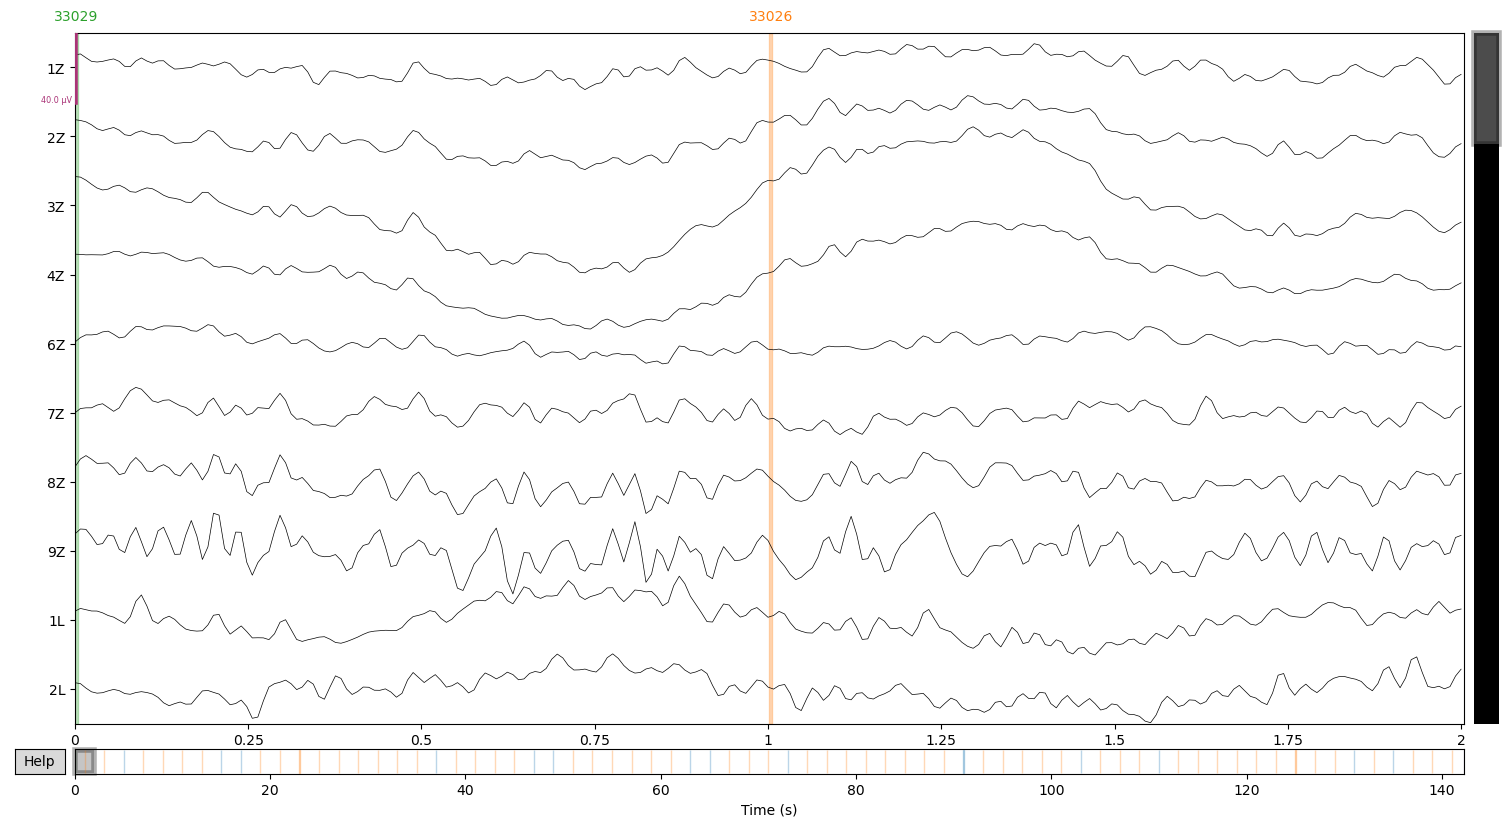

In [4]:
pnum = 1
b_cnt  = 0
block_num =  'D0'

raw = analysis.processing.loadSegmentedData(pnum, block_num)
raw = raw.apply_function(lambda x: x * 1e6)
raw.plot(duration= 2, use_opengl= True,  n_channels= 10)

[[0.5, 4.0], [4.0, 8.0], [8.0, 13.0], [13.0, 30.0]]

In [ ]:
con_epochs_array = np.mean(con_epochs_array, axis=4)  # average over timepoints

# In this example, we will just show alpha
foi = list(Freq_Bands.keys()).index("alpha")  # frequency of interest


# Define function for plotting con matrices
def plot_con_matrix(con_data, n_con_methods):
    """Visualize the connectivity matrix."""
    fig, ax = plt.subplots(1, n_con_methods, figsize=(6 * n_con_methods, 6))
    for c in range(n_con_methods):
        # Plot with imshow
        con_plot = ax[c].imshow(con_data[c, :, :, foi], cmap="binary", vmin=0, vmax=1)
        # Set title
        ax[c].set_title(connectivity_methods[c])
        # Add colorbar
        fig.colorbar(con_plot, ax=ax[c], shrink=0.7, label="Connectivity")
        # Fix labels
        ax[c].set_xticks(range(len(ch_names)))
        ax[c].set_xticklabels(ch_names)
        ax[c].set_yticks(range(len(ch_names)))
        ax[c].set_yticklabels(ch_names)
        print(
            f"Connectivity method: {connectivity_methods[c]}\n"
            + f"{con_data[c,:,:,foi]}"
        )
    return fig


plot_con_matrix(con_epochs_array, n_con_methods)

In [28]:
con_time

<EpochSpectralConnectivity | n_epochs : 3, freq : [17.000000, 17.000000], , nave : None, nodes, n_estimated : 62, 3844, ~95 kB>

In [22]:
raw.ch_names

['1Z',
 '2Z',
 '3Z',
 '4Z',
 '6Z',
 '7Z',
 '8Z',
 '9Z',
 '1L',
 '2L',
 '3L',
 '4L',
 '5L',
 '6L',
 '7L',
 '8L',
 '9L',
 '10L',
 '1R',
 '2R',
 '3R',
 '4R',
 '5R',
 '6R',
 '7R',
 '8R',
 '9R',
 '10R',
 '1LA',
 '2LA',
 '3LA',
 '1LB',
 '2LB',
 '3LB',
 '4LB',
 '5LB',
 '1LC',
 '2LC',
 '3LC',
 '4LC',
 '5LC',
 '1LD',
 '2LD',
 '3LD',
 '4LD',
 '1RA',
 '2RA',
 '3RA',
 '1RB',
 '2RB',
 '3RB',
 '4RB',
 '5RB',
 '1RC',
 '2RC',
 '3RC',
 '4RC',
 '5RC',
 '1RD',
 '2RD',
 '3RD',
 '4RD']

In [17]:
freqs

array([ 4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,
        6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,
        8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 ,
       10.75, 11.  , 11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75,
       13.  , 13.25, 13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  ,
       15.25, 15.5 , 15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25,
       17.5 , 17.75, 18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 ,
       19.75, 20.  , 20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75,
       22.  , 22.25, 22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  ,
       24.25, 24.5 , 24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25,
       26.5 , 26.75, 27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 ,
       28.75, 29.  , 29.25, 29.5 , 29.75, 30.  ])

In [13]:
from mne_connectivity.viz import plot_sensors_connectivity
# Now, visualize the connectivity in 3D:
plot_sensors_connectivity(info = epochs.info, con = corr_matrix[-1])

In [11]:
pnum = 1
b_cnt  = 0
block_num =  'ND0'

raw = analysis.processing.loadSegmentedData(pnum, block_num)
epochs = mne.make_fixed_length_epochs(raw, duration= 30, preload=False)


corr_matrix = envelope_correlation(epochs).get_data()
print(corr_matrix.shape)


import matplotlib.pyplot as plt
import numpy as np

first_30 = corr_matrix[0]
last_30 = corr_matrix[-1]
corr_matrices = [first_30, last_30]
color_lims = np.percentile(np.array(corr_matrices), [5, 95])
titles = ["First 30 Seconds", "Last 30 Seconds"]

fig, axes = plt.subplots(nrows=1, ncols=2,  constrained_layout=True)
fig.suptitle("Correlation Matrices from First 30 Seconds and Last 30 Seconds")
for ci, corr_matrix in enumerate(corr_matrices):
    ax = axes[ci]
    mpbl = ax.imshow(corr_matrix, clim=color_lims)
    ax.set_xlabel(titles[ci])
cbar = fig.colorbar(ax.images[0], label="Correlation Coefficient")

(3, 62, 62, 1)


In [ ]:
# read group evokeds

oddball_list = []
control_list = []

for pnum in (11, 12, 13, 21, 22, 23, 41, 42, 43, 51, 52, 53, 61, 62, \
             63, 71, 72, 73, 81, 82, 83, 91, 92, 93, 101, 102, 103):
    raw = analysis.processing.loadData(pnum)

    # preprocessig 
    raw = analysis.processing.preprocessing(raw)
    epochs, event_dict = analysis.processing.eventEpocshByBlocks(raw)

    for bnum in (0, 1, 2):
        block = "b" + str(bnum)

        oddball = epochs[f"oddball & block == '{block}'"].average()
        control = epochs[f"control & block == '{block}'"].average()
        oddball_list.append(oddball)
        control_list.append(control)



title= "ERP"
roi =['7Z']

evokeds = dict(
    oddball=  oddball_list,
    control= control_list,
)

c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:46: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:46: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:46: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:46: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filtered.set_montage(montage)
c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:46: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_filte

In [ ]:
analysis.processing.getERPMontage(evokeds)

In [ ]:
#plot evokeds at 0.95 CI
analysis.processing.getERP(evokeds, roi = ['7Z'], ci = 0.95, invert = True)

In [ ]:
#plot evokeds at 0.9 CI
analysis.processing.getERP(evokeds, roi = ['7Z'], ci = 0.9, invert = True)

In [ ]:
#front

roi = ['1L', '1R','1Z','1LC', '1LB', '2L', '2R', '1RB', '1RC']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")

plt.show()

In [ ]:
#Occipital

roi = ['10L', '9Z','10R', '9L', '8Z', '9R']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")

plt.show()

In [ ]:
#Left

roi = ['3LB', '3LC','2LB', '1LA', '2LA', '2LC']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")

plt.show()

In [ ]:
#Right

roi = ['3RB', '3RC','2RB', '1RA', '2RA', '2RC']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")

plt.show()